In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import loadtxt
import os, glob
import geopandas as gpd
import geojsonio
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import math
from IPython.display import Image

import plotly
import plotly.express as px
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline
#pd.options.plotting.backend = "plotly"

In [2]:
# Dashboard
target="price_log"
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = 300
pd.set_option('display.max_colwidth', 150)
sns.set(style="white")

In [3]:
# Import data_engineered
data = pd.read_pickle("saves/data_engineered.pkl")

In [4]:
# Alternative: Import from csv
#data_types_clean = pd.read_csv('saves/types_clean.csv')['types']
#data = pd.read_csv("saves/data_clean.csv", dtype=data_types_clean.to_dict())
#data.set_index('id', inplace=True)

# Data Exploration

In [5]:
# Separate/create variables for numerical and categorical features
num_features = list(data.columns[data.dtypes!=object])
cat_features = list(data.columns[data.dtypes==object])
#data_cont = data[num_features]

## Interactive Dashboards

In [6]:
# Display figures from graphical exploration below direcly here in the dashboard
@interact_manual
def show_images(file=os.listdir('data/figures/')):
    display(Image("data/figures/"+file))

interactive(children=(Dropdown(description='file', options=('3_fig1_heatmap.png', 'fig1_heatmap.png', 'fig3_ma…

In [7]:
# Display table with all rows where feature value is > x (where x is the selected threshold)
@interact(x=widgets.IntSlider(1,0,100,1,continuous_update=False))
def filter_data(column=num_features, x=10):
    return data.loc[data[column]>x]

interactive(children=(Dropdown(description='column', options=('accommodates', 'accommodates_per_bed', 'am_balc…

In [16]:
# Display interactive plot for comparing two features
@interact_manual(x=widgets.Dropdown(options=list(data.select_dtypes('number').columns),index=0,description="Feature"),
                 y=widgets.Dropdown(options=list(data.select_dtypes('number').columns),value=target,description="Target"),
                 kind=widgets.Dropdown(options=["bar", "box", "bubble", "heatmap", "histogram", "scatter"],value="bar",description="Plot Type"))
#                 text='title',
#                 theme=widgets.Dropdown(options=list(cf.themes.THEMES.keys()),description="Theme"),
#                 colorscale=widgets.Dropdown(options=list(cf.colors._scales_names.keys()),description="Colorscale"))


def scatter_plot(x,y, kind):#,theme,colorscale):

    data.iplot(
        kind=kind,
        x=x,
        y=y,
        mode='markers',
        xTitle=str(x),
        yTitle=str(y),
        title=f'{str(y)} vs {str(x)}')
#        text=title,
#        theme=theme,
#        colorscale=colorscale)

interactive(children=(Dropdown(description='Feature', options=('accommodates', 'accommodates_per_bed', 'am_bal…

## Tables (non-graphical exploration)

In [9]:
# Examine shape and head/columns of data
print(data.shape)
data.head(1)

(10693, 38)


,accommodates,accommodates_per_bed,am_balcony,am_breakfast,am_child_friendly,am_elevator,am_essentials,am_nature_and_views,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,availability_90,bathrooms_log,bedrooms,calculated_host_listings_count,cancellation_policy,first_review_days,host_is_superhost,instant_bookable,last_review_days,latitude,longitude,maximum_nights,minimum_nights_log,neighbourhood,occupancy_class,occupancy_rate,price_extra_fees_sqrt,price_extra_people,price_log,property_type,review_scores_rating_sqrt,room_type,text_len_sqrt,wk_mth_discount,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,4,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,1,strict,3923,0,0,264,52.535,13.41758,1125,7.874008,Prenzlauer Berg,0,0.0,20.0,16.666667,4.382027,Apartment,6.298521,Entire home/apt,0.771052,0.23545,zip_10405


**Outliers**

**Skew**

In [10]:
# Look at data skew (to check whether scaling with e.g. log makes sense for highly skewed features)
data.skew()

accommodates                      2.284099
accommodates_per_bed              3.353649
am_balcony                        1.025149
am_breakfast                      4.169594
am_child_friendly                 0.868092
am_elevator                       1.187610
am_essentials                    -4.675241
am_nature_and_views               4.842356
am_pets_allowed                   1.716274
am_private_entrance               1.322389
am_smoking_allowed                2.093351
am_tv                            -0.093822
am_white_goods                   -1.696731
availability_90                   0.227368
bathrooms_log                     2.585705
bedrooms                          2.581845
calculated_host_listings_count    5.258207
first_review_days                 1.210431
host_is_superhost                 0.879274
instant_bookable                  0.388159
last_review_days                  1.685405
latitude                         -0.125844
longitude                        -0.215151
maximum_nig

Based on skew, log/sqrt shall replace the original feature for:

| **FEATURE** | **METHOD** |
| :----- | :----- |
| **accommodates** | log |
| **bathrooms** | log |
| **minimum_nights** | log |
| **price** | log |
| **review_scores_rating** | sqrt |


**Correlation**

In [11]:
# Interactive feature vs. feature correlation check
@interact
def correlations(column1=list(data.select_dtypes('number').columns),
                 column2=list(data.select_dtypes('number').columns)):
    print(f"Correlation: {data[column1].corr(data[column2])}")

interactive(children=(Dropdown(description='column1', options=('accommodates', 'accommodates_per_bed', 'am_bal…

In [12]:
# Full list of correlation values
data.corr()

,accommodates,accommodates_per_bed,am_balcony,am_breakfast,am_child_friendly,am_elevator,am_essentials,am_nature_and_views,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,availability_90,bathrooms_log,bedrooms,calculated_host_listings_count,first_review_days,host_is_superhost,instant_bookable,last_review_days,latitude,longitude,maximum_nights,minimum_nights_log,occupancy_class,occupancy_rate,price_extra_fees_sqrt,price_extra_people,price_log,review_scores_rating_sqrt,text_len_sqrt,wk_mth_discount
accommodates,1.000000,0.187777,0.061375,-0.023703,0.303138,0.051089,-0.031644,-0.001758,0.084838,0.163442,-0.099172,0.257933,0.030720,0.110037,0.311727,0.706251,0.228268,0.068245,-0.008047,0.108926,-0.053878,0.015079,0.007548,0.123462,-0.066203,0.100110,0.101944,0.215249,0.315519,0.488565,-0.127589,0.159367,-0.004275
accommodates_per_bed,0.187777,1.000000,0.032328,0.008568,0.047677,0.054789,-0.071599,-0.005016,0.029437,0.002416,0.008780,0.040312,0.044326,-0.025732,-0.016257,-0.074983,0.055623,0.010118,0.000231,0.027169,-0.026535,0.010930,0.027244,0.037976,-0.040610,0.009303,0.013555,0.022683,0.160044,0.127141,-0.004534,0.030707,-0.003964
am_balcony,0.061375,0.032328,1.000000,-0.009764,0.097534,0.156088,0.072892,0.103337,0.009862,0.039231,0.010488,0.104728,0.146315,-0.033979,0.091008,0.090549,-0.087444,0.035187,0.118513,-0.014993,-0.015772,0.011084,0.004384,-0.021420,0.004991,-0.008165,-0.009084,0.114724,0.066322,0.132921,0.100478,0.126048,0.025686
am_breakfast,-0.023703,0.008568,-0.009764,1.000000,-0.030449,0.003286,0.029025,0.004706,0.034482,0.000041,0.033986,-0.027119,-0.003547,0.008125,-0.017935,-0.022036,-0.048997,-0.073594,-0.022830,0.022995,0.031556,-0.005650,-0.012468,-0.011816,-0.045988,-0.056544,-0.061284,-0.039729,0.006906,0.014450,0.049315,-0.015142,-0.032481
am_child_friendly,0.303138,0.047677,0.097534,-0.030449,1.000000,0.034823,-0.008597,0.012943,0.069173,0.022650,-0.081279,0.169667,0.034321,0.057583,0.102136,0.263179,0.058718,0.437487,0.063022,0.013090,0.017418,0.004456,0.015467,0.026196,0.030913,0.046680,0.054658,0.161703,0.179590,0.211452,-0.103025,0.196082,0.171477
am_elevator,0.051089,0.054789,0.156088,0.003286,0.034823,1.000000,-0.012738,0.034048,-0.018595,0.002146,-0.017292,0.149903,0.062791,0.051698,0.104426,0.028033,0.101937,-0.002968,0.031867,0.017180,0.024454,0.045787,-0.043702,0.029828,0.041371,0.012580,0.018674,0.079700,0.029585,0.202216,-0.008088,0.027848,-0.008253
am_essentials,-0.031644,-0.071599,0.072892,0.029025,-0.008597,-0.012738,1.000000,0.020735,0.016505,0.056608,0.016098,-0.016568,0.052252,-0.013564,-0.009326,0.006076,-0.201105,-0.079805,0.095342,0.024652,-0.048275,-0.006892,0.010552,0.012458,-0.028998,0.034969,0.042905,0.030168,-0.034112,0.017713,0.073331,0.037898,-0.059094
am_nature_and_views,-0.001758,-0.005016,0.103337,0.004706,0.012943,0.034048,0.020735,1.000000,0.027580,0.050712,-0.005805,0.040228,0.003223,0.025619,0.015011,0.002296,-0.025469,-0.014404,0.041729,-0.001920,0.004784,-0.046479,0.003389,0.007070,-0.019917,0.003354,-0.005108,0.018910,0.016920,-0.003637,0.006388,0.027137,-0.009389
am_pets_allowed,0.084838,0.029437,0.009862,0.034482,0.069173,-0.018595,0.016505,0.027580,1.000000,0.015810,0.139621,0.019644,0.012469,0.039150,0.030587,0.042601,-0.021330,0.027463,-0.003365,0.048773,0.003585,-0.041720,0.023949,0.021395,-0.048660,-0.009727,-0.004307,-0.039133,0.032276,0.015737,-0.036407,0.005785,-0.001881
am_private_entrance,0.163442,0.002416,0.039231,0.000041,0.022650,0.002146,0.056608,0.050712,0.015810,1.000000,-0.070186,0.132354,-0.063860,0.062903,0.036230,0.092417,0.029348,-0.127167,0.024734,0.125349,-0.035968,0.000756,0.010162,0.025256,-0.017322,0.061506,0.064045,0.074494,0.024434,0.194584,0.001864,0.036200,-0.068350


## Plot visualizations (graphical exploration)

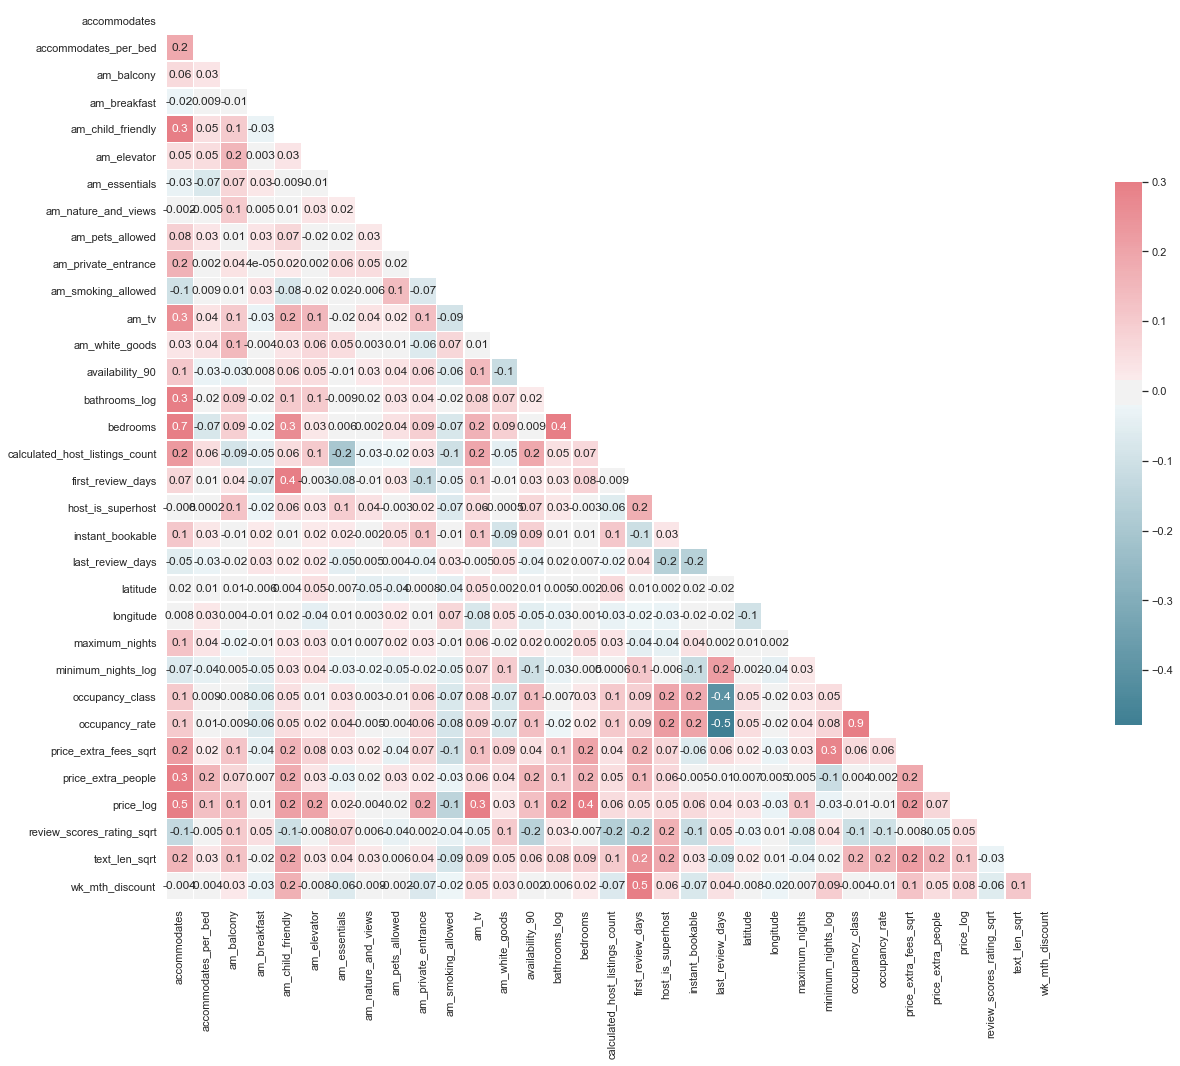

In [13]:
# Plot correlation heatmap for numerical features
#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data[num_features].corr(), dtype=np.bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data[num_features].corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1g");

plt.savefig("data/figures/fig1_heatmap.png")

Highly correlated features will be removed from the analysis. For this purpose, the threshold is set at two correlations of 0.4 or above. Hence, the following features are removed:

| **FEATURE** | **REASONING** |
| :----- | :----- |
| **** |  |



In [14]:
# Plot median comparison for all t/f features


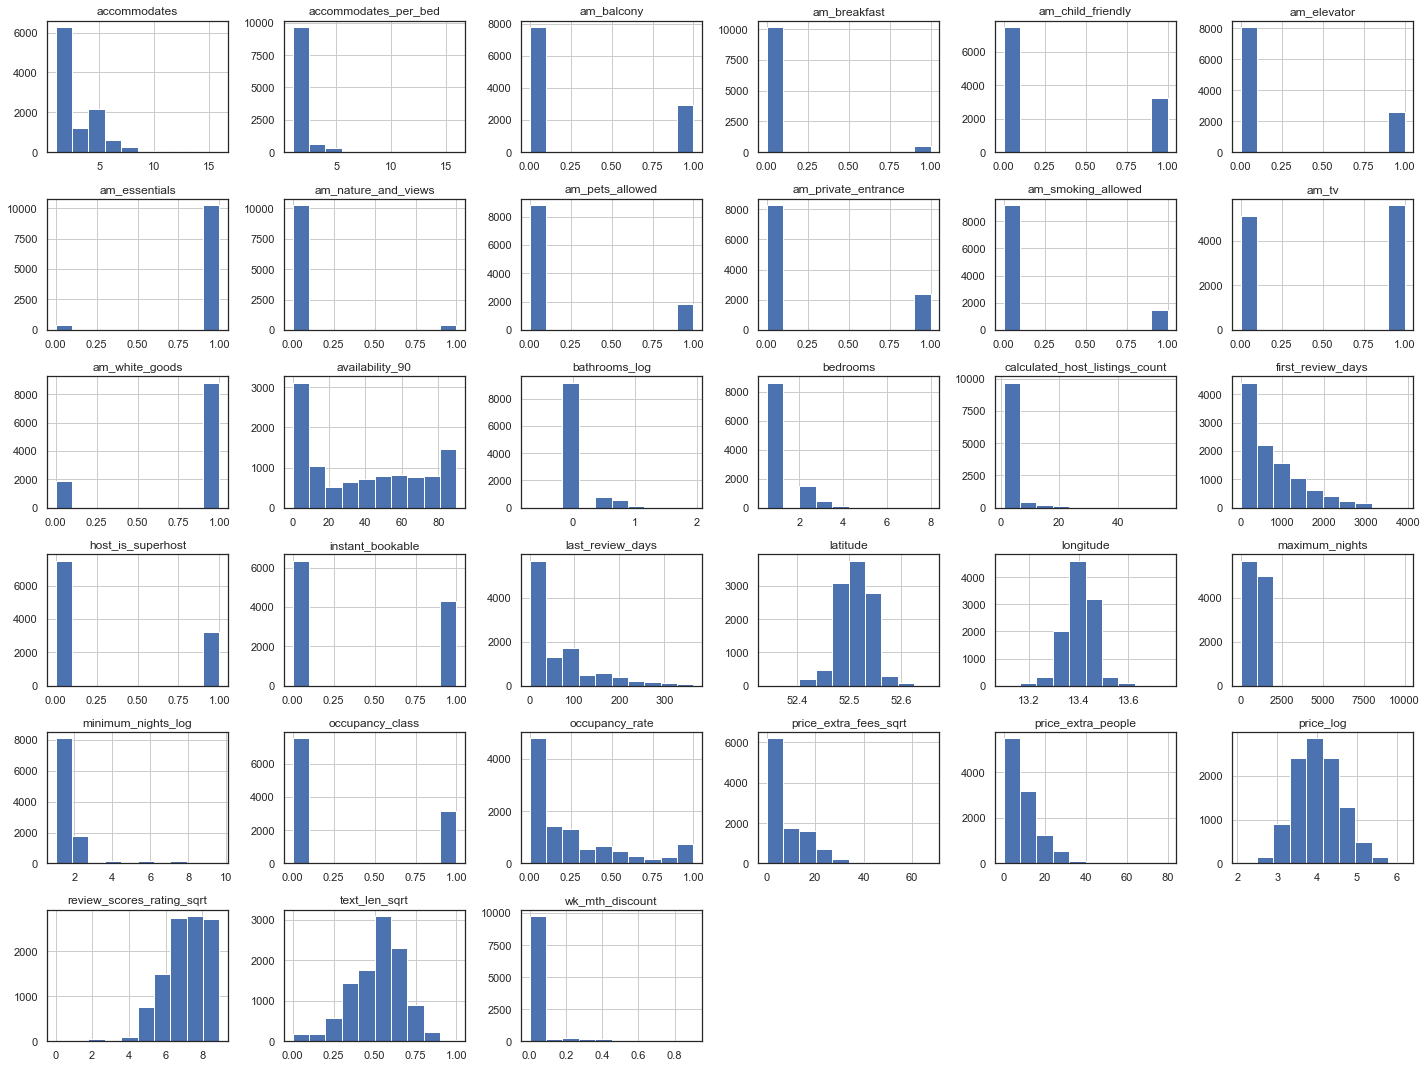

In [15]:
# Plot histogram of numerical features
data[num_features].hist(figsize=(20,15));
plt.tight_layout()